<a href="https://colab.research.google.com/github/HebahAlshamlan/CITC_Task/blob/master/CITC_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
pd.set_option('max_colwidth',400)

# load dataset

In [ ]:
dataset = pd.read_csv('cars.csv')
print(dataset.shape)

dataset.head()

(301, 8)


,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price
0,ritz,2014.0,27000,Petrol,Dealer,Manual,0,3.35
1,sx4,2013.0,43000,Diesel,Dealer,Manual,0,4.75
2,ciaz,2017.0,6900,Petrol,Dealer,Manual,0,7.25
3,wagon r,2011.0,5200,Petrol,Dealer,Manual,0,2.85
4,swift,2014.0,42450,Diesel,Dealer,Manual,0,4.60


In [ ]:
dataset.dtypes


car_name              object
year                 float64
mileage                int64
fuel_type             object
seller_type           object
transmission_type     object
previous_owners        int64
selling_price        float64
dtype: object

In [ ]:
# Find what the duplicate were
dataset.drop_duplicates(subset=None, inplace=True)
dataset.shape

(299, 8)

# Exploratory Data Analysis

<Figure size 1440x720 with 0 Axes>

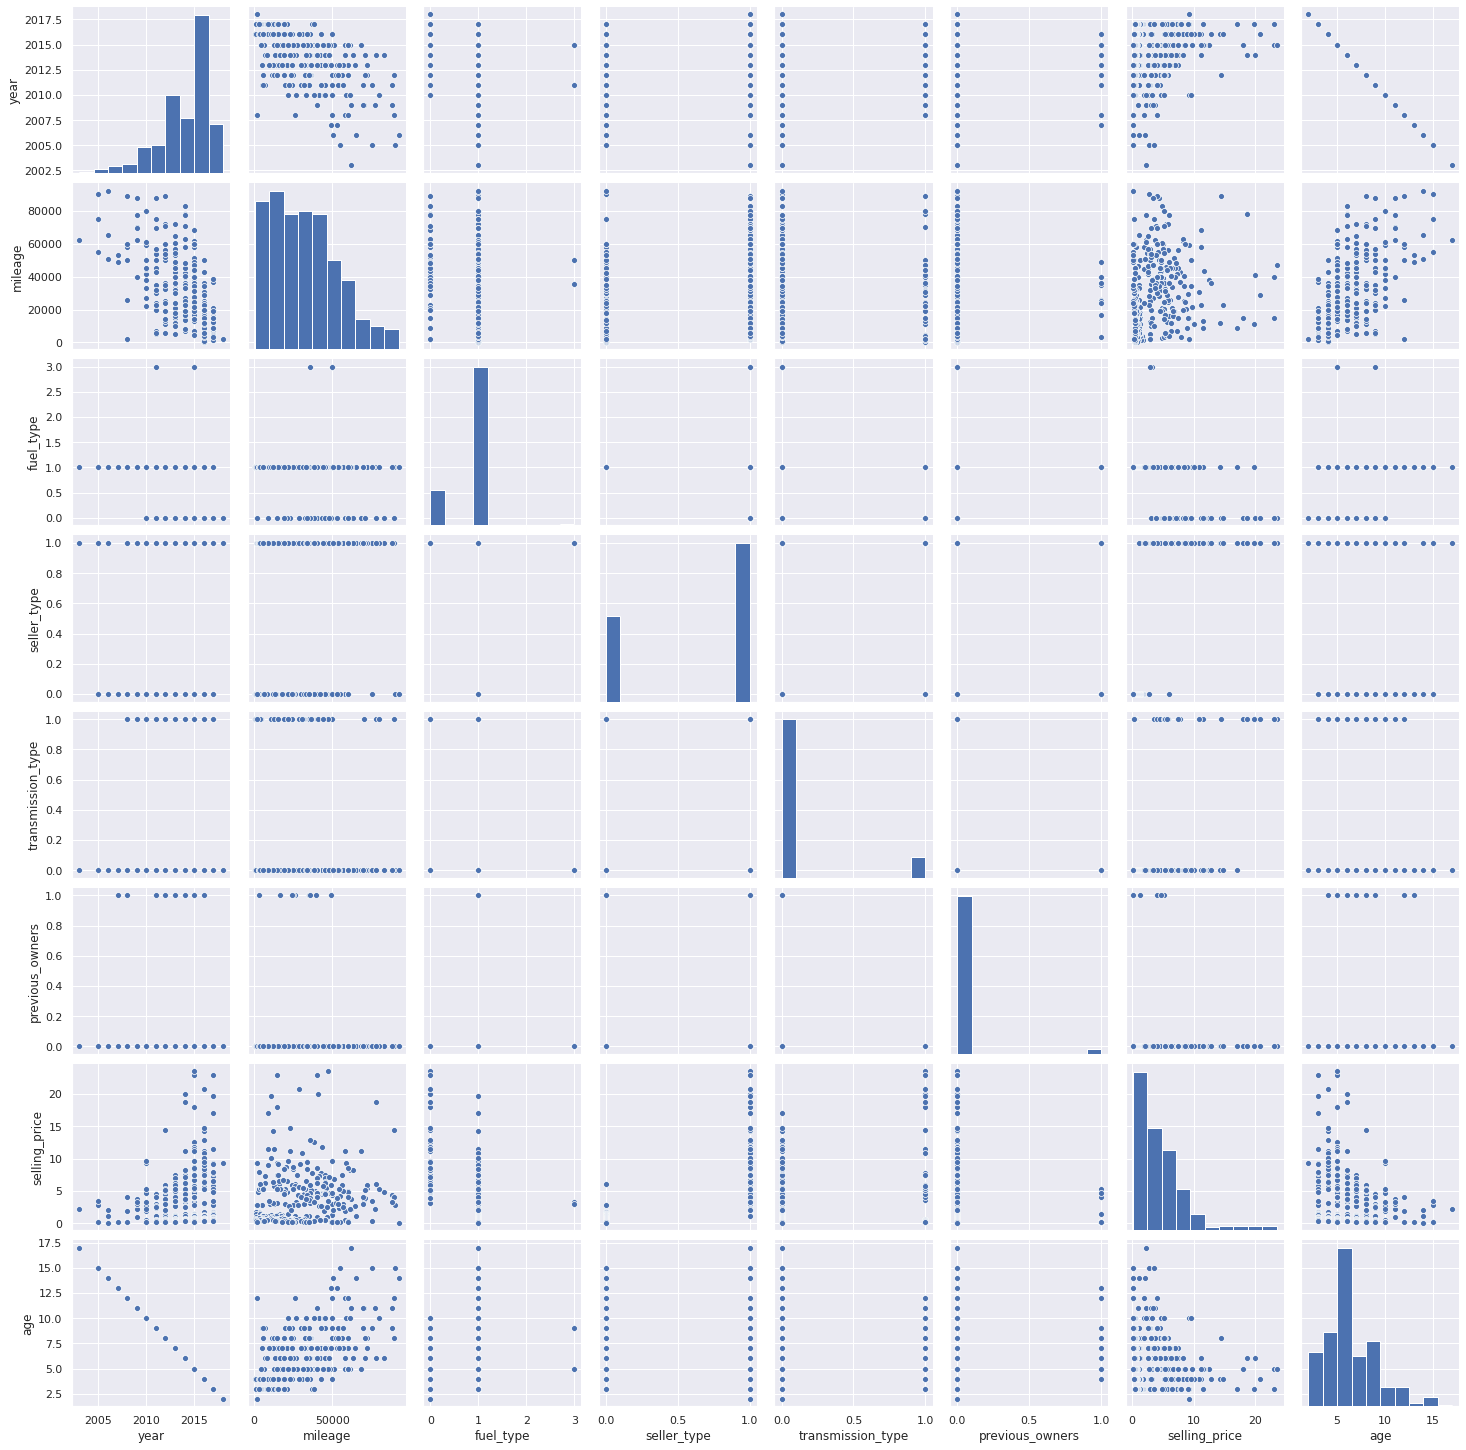

In [ ]:
# paiwise scatter plot
plt.figure(figsize=(20, 10))
sns.pairplot(dataset)

#as we can see its difficult to interpret these graphs due to somany of them
#a BETTER way of checking linearity is in below cell

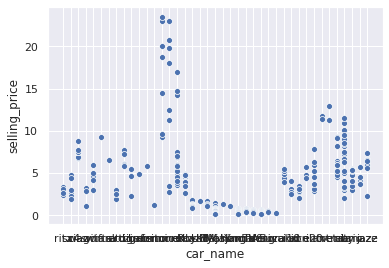

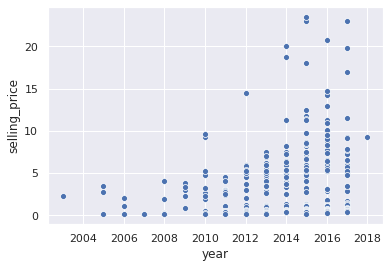

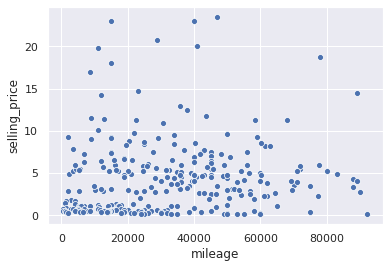

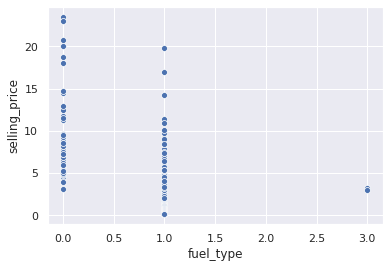

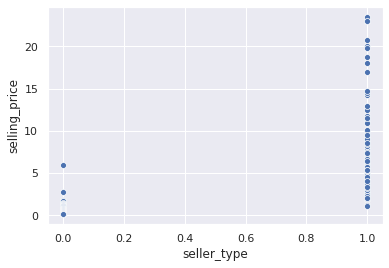

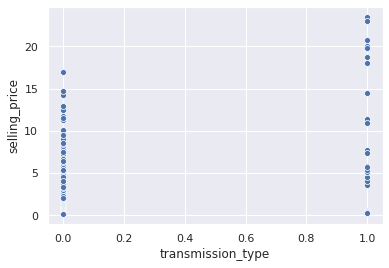

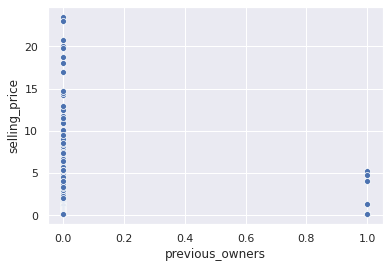

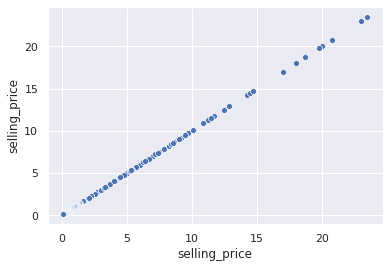

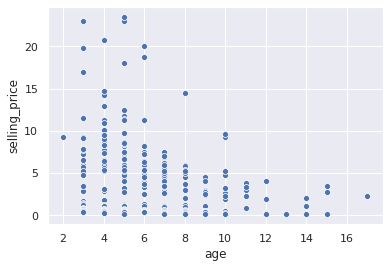

In [ ]:
#LINEARITY CHECK>>>#to check price has linear relation or not with Indep. var's

for i, col in enumerate (dataset.columns):
    plt.figure(i)
    sns.scatterplot(x=dataset[col],y=dataset['selling_price'])

* These var's appears to **not** have a linear relation with price.

* Other variables either don't have a relation with price or relationship isn't strong. None of the varibales appear to have polynomial relation with price.


## Selling price

In [ ]:
print(dataset.selling_price.mean())
print(dataset.selling_price.median()) # There is NO big difference between mean and median which indicates no outliers.
print(dataset.selling_price.max())
print(dataset.selling_price.min())

4.57063758389262
3.505
35.0
0.1


In [ ]:
dataset.selling_price.sort_values(ascending=False) # OBSERVATION: we have two large values

86     35.00
64     33.00
63     23.50
82     23.00
51     23.00
       ...  
197     0.16
198     0.15
199     0.12
200     0.10
256      NaN
Name: selling_price, Length: 299, dtype: float64

In [ ]:
print(dataset.selling_price.mean())
print(dataset.selling_price.median())
dataset.selling_price.mode()


4.57063758389262
3.505


0    0.45
1    0.60
dtype: float64

In [ ]:
sns.set(style='darkgrid') # style must be one of white, dark, whitegrid, darkgrid, ticks

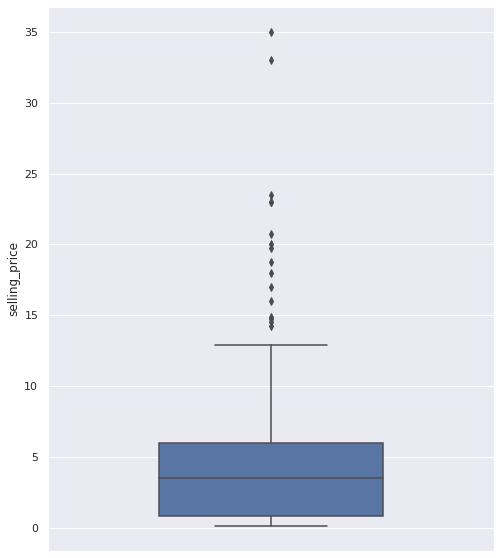

In [ ]:
plt.figure(figsize=(8,10))
sns.boxplot(y='selling_price', data=dataset, width=0.5) #from the box plot we can see the two highest values

Text(0.5, 1.0, 'Frequency Distribution Plot of Prices')

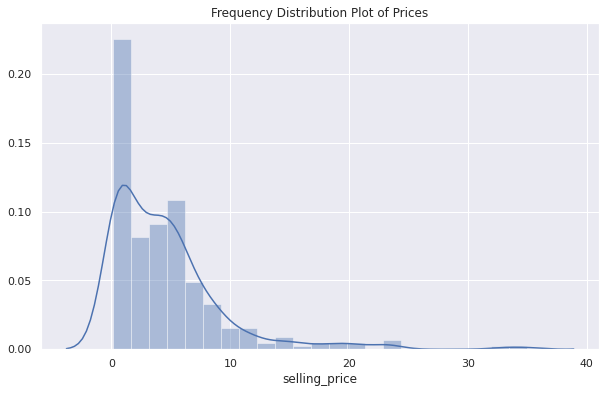

In [ ]:
x = dataset.selling_price
plt.figure(figsize=(10,6))
sns.distplot(x).set_title('Frequency Distribution Plot of Prices')

In [ ]:
dataset = dataset[dataset.selling_price <= 30.00 ] #remove the outliers

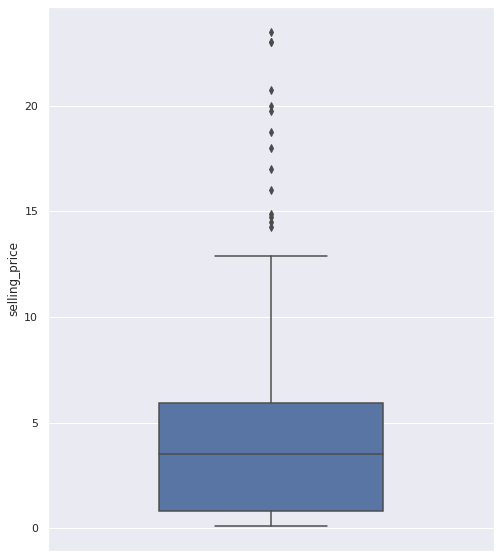

In [ ]:
plt.figure(figsize=(8,10))
sns.boxplot(y='selling_price', data=dataset, width=0.5)

## Convert to numeric representation
fuel_type,	seller_type, and	transmission_type

In [ ]:
# Convert data to binery
dataset = dataset.replace('Petrol','1',regex=True)
dataset = dataset.replace('Diesel','0',regex=True)
dataset = dataset.replace('Dealer','1',regex=True)
dataset = dataset.replace('Individual','0',regex=True)
dataset = dataset.replace('Automatic','1',regex=True)
dataset = dataset.replace('Manual','0',regex=True)
dataset = dataset.replace('CNG','3',regex=True)
dataset["seller_type"] = pd.to_numeric(dataset["seller_type"], downcast="float")
dataset["previous_owners"] = pd.to_numeric(dataset["previous_owners"], downcast="float")
dataset["fuel_type"] = pd.to_numeric(dataset["fuel_type"], downcast="float")
dataset["transmission_type"] = pd.to_numeric(dataset["transmission_type"], downcast="float")


## Missing values


In [ ]:
dataset.isna().any()
dataset.isna().sum() #we have 2 missing values in year and name

car_name             1
year                 2
mileage              0
fuel_type            0
seller_type          0
transmission_type    0
previous_owners      0
selling_price        0
dtype: int64

In [ ]:
# coz it just one value and the price of that car in the avreage, it's better to deleting it
dataset = dataset.dropna(subset=['car_name'])

In [ ]:
# the mean have been taking for the missing years
dataset.fillna(dataset['year'].mode()[0], inplace=True) 

In [ ]:
dataset.head()

,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price
0,ritz,2014.0,27000,1.0,1.0,0.0,0.0,3.35
1,sx4,2013.0,43000,0.0,1.0,0.0,0.0,4.75
2,ciaz,2017.0,6900,1.0,1.0,0.0,0.0,7.25
3,wagon r,2011.0,5200,1.0,1.0,0.0,0.0,2.85
4,swift,2014.0,42450,0.0,1.0,0.0,0.0,4.60


## Year
The age of the car definitely effects the prices. However, instead of the model year of the car, it makes more sense to use is as age. So I will substiture 'year' column from current year.

In [ ]:
dataset.year.value_counts() 

2015.0    62
2016.0    47
2014.0    38
2013.0    33
2017.0    33
2012.0    23
2011.0    19
2010.0    13
2008.0     7
2009.0     6
2005.0     4
2006.0     4
2003.0     2
2007.0     2
2004.0     1
2018.0     1
Name: year, dtype: int64

In [ ]:
dataset['age'] = 2020 - dataset['year'] # now we have age as new feature insted of year
dataset.head()

,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price,age
0,ritz,2014.0,27000,1.0,1.0,0.0,0.0,3.35,6.0
1,sx4,2013.0,43000,0.0,1.0,0.0,0.0,4.75,7.0
2,ciaz,2017.0,6900,1.0,1.0,0.0,0.0,7.25,3.0
3,wagon r,2011.0,5200,1.0,1.0,0.0,0.0,2.85,9.0
4,swift,2014.0,42450,0.0,1.0,0.0,0.0,4.60,6.0


Text(0.5, 1.0, 'Frequency Distribution Plot of Age of the Cars')

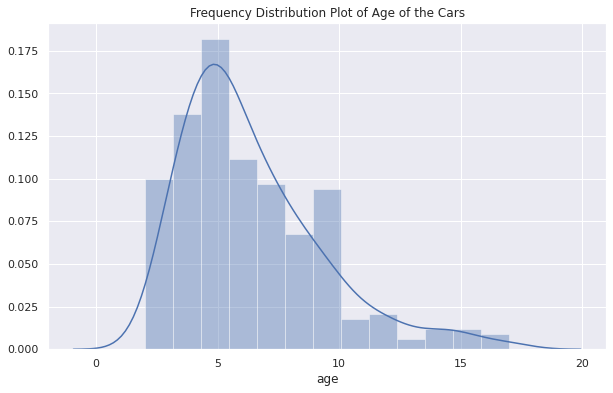

In [ ]:
a = dataset.age
plt.figure(figsize=(10,6))
sns.distplot(a).set_title('Frequency Distribution Plot of Age of the Cars')

## mileage

In [ ]:
print(dataset.mileage.mean())
print(dataset.mileage.median())

36767.95593220339
31604.0


Text(0.5, 1.0, 'Frequency Distribution Plot of Km')

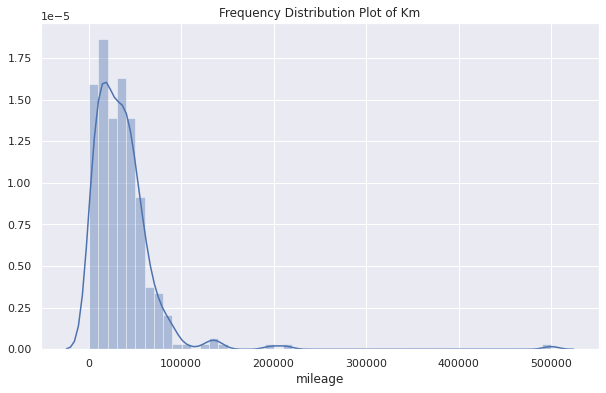

In [ ]:
k = dataset.mileage
plt.figure(figsize=(10,6))
sns.distplot(k).set_title('Frequency Distribution Plot of Km')

In [ ]:
dataset = dataset[dataset.mileage <= 400000 ] #drop the outliers

Text(0.5, 1.0, 'Frequency Distribution Plot of Km')

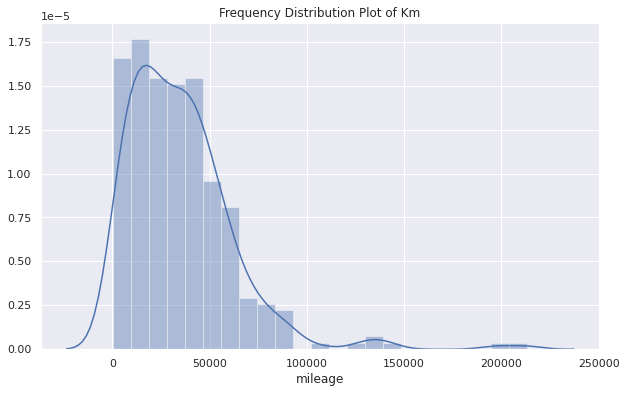

In [ ]:
k = dataset.mileage
plt.figure(figsize=(10,6))
sns.distplot(k).set_title('Frequency Distribution Plot of Km')

## Car Name

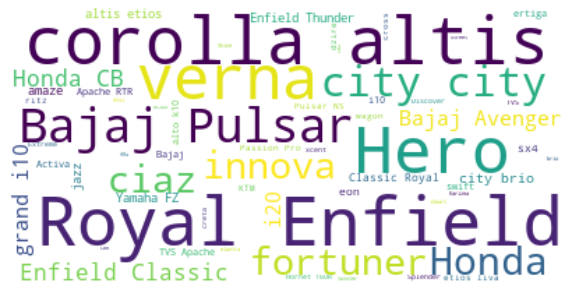

In [ ]:
from wordcloud import WordCloud, STOPWORDS 

len(dataset.car_name)

dataset.car_name[1]

dataset['car_name'] = dataset['car_name'].astype(str)
text_list = list(dataset.car_name)

text = '-'.join(text_list)

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
dataset['car_name'].unique()

array(['ritz', 'sx4', 'ciaz', 'wagon r', 'swift', 'vitara brezza',
       's cross', 'alto 800', 'ertiga', 'dzire', 'alto k10', 'ignis',
       '800', 'baleno', 'omni', 'fortuner', 'innova', 'corolla altis',
       'etios cross', 'etios g', 'etios liva', 'corolla', 'etios gd',
       'camry', 'Royal Enfield Thunder 500', 'UM Renegade Mojave',
       'KTM RC200', 'Bajaj Dominar 400', 'Royal Enfield Classic 350',
       'KTM RC390', 'Hyosung GT250R', 'Royal Enfield Thunder 350',
       'KTM 390 Duke ', 'Mahindra Mojo XT300', 'Bajaj Pulsar RS200',
       'Royal Enfield Bullet 350', 'Royal Enfield Classic 500',
       'Bajaj Avenger 220', 'Bajaj Avenger 150', 'Honda CB Hornet 160R',
       'Yamaha FZ S V 2.0', 'Yamaha FZ 16', 'TVS Apache RTR 160',
       'Bajaj Pulsar 150', 'Honda CBR 150', 'Hero Extreme',
       'Bajaj Avenger 220 dtsi', 'Bajaj Avenger 150 street',
       'Yamaha FZ  v 2.0', 'Bajaj Pulsar  NS 200', 'Bajaj Pulsar 220 F',
       'TVS Apache RTR 180', 'Hero Passion X pro', '

In [ ]:
dataset.car_name.value_counts()


city                   25
corolla altis          16
verna                  14
brio                   10
fortuner                9
                       ..
Yamaha Fazer            1
Hero Super Splendor     1
Bajaj  ct 100           1
Hero Glamour            1
vitara brezza           1
Name: car_name, Length: 97, dtype: int64

In [ ]:
stopwords = ['corolla altis', 'royal', 'Enfield', 'Hero', 'city','Bajaj','verba','i20','fortuner']

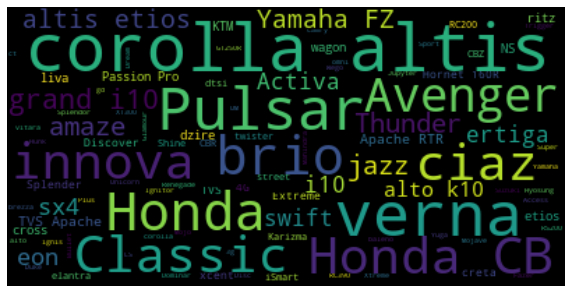

In [ ]:

wordcloud = WordCloud(stopwords=stopwords).generate(text)


plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


It is clear from the data above that the names of cars and motorcycles begin with the name of the company, and that textual data must be converted into a numeric representation, i thought of two solutions:
- Cropping company names out of car names
-  Training the models without the names

Then to convert the texts to numeric representation there's two ideas:
-  Using the idea of one-hot-encoding

or
-  Converting all the names into a numbers from 1 to the last one, then do a sceling 

In [ ]:
# Cropping company names out of car names
for ind in dataset.index: 
     dataset['car_name'][ind] = dataset.car_name[ind].split()[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# use one hot encoding
y = pd.get_dummies(dataset.car_name)
y

,800,Activa,Bajaj,Hero,Honda,Hyosung,KTM,Mahindra,Royal,Suzuki,TVS,UM,Yamaha,alto,amaze,baleno,brio,camry,ciaz,city,corolla,creta,dzire,elantra,eon,ertiga,etios,fortuner,grand,i10,i20,ignis,innova,jazz,omni,ritz,s,swift,sx4,verna,vitara,wagon,xcent
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# combine DataFrames 
vertical_stack = pd.concat([y, dataset], axis=1)
vertical_stack

,800,Activa,Bajaj,Hero,Honda,Hyosung,KTM,Mahindra,Royal,Suzuki,TVS,UM,Yamaha,alto,amaze,baleno,brio,camry,ciaz,city,corolla,creta,dzire,elantra,eon,ertiga,etios,fortuner,grand,i10,i20,ignis,innova,jazz,omni,ritz,s,swift,sx4,verna,vitara,wagon,xcent,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price,age
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,ritz,2014.0,27000,1.0,1.0,0.0,0.0,3.35,6.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,sx4,2013.0,43000,0.0,1.0,0.0,0.0,4.75,7.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ciaz,2017.0,6900,1.0,1.0,0.0,0.0,7.25,3.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,wagon,2011.0,5200,1.0,1.0,0.0,0.0,2.85,9.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,swift,2014.0,42450,0.0,1.0,0.0,0.0,4.60,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,city,2016.0,33988,0.0,1.0,0.0,0.0,9.50,4.0
297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,brio,2015.0,60000,1.0,1.0,0.0,0.0,4.00,5.0
298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,city,2009.0,87934,1.0,1.0,0.0,0.0,3.35,11.0
299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,city,2017.0,9000,0.0,1.0,0.0,0.0,11.50,3.0


In [ ]:
dataset


,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price,age
0,ritz,2014.0,27000,1.0,1.0,0.0,0.0,3.35,6.0
1,sx4,2013.0,43000,0.0,1.0,0.0,0.0,4.75,7.0
2,ciaz,2017.0,6900,1.0,1.0,0.0,0.0,7.25,3.0
3,wagon,2011.0,5200,1.0,1.0,0.0,0.0,2.85,9.0
4,swift,2014.0,42450,0.0,1.0,0.0,0.0,4.60,6.0
...,...,...,...,...,...,...,...,...,...
296,city,2016.0,33988,0.0,1.0,0.0,0.0,9.50,4.0
297,brio,2015.0,60000,1.0,1.0,0.0,0.0,4.00,5.0
298,city,2009.0,87934,1.0,1.0,0.0,0.0,3.35,11.0
299,city,2017.0,9000,0.0,1.0,0.0,0.0,11.50,3.0


In [ ]:
dataset.car_name[100] #test

'Royal'

# Feature Extraction

Text(0.5, 1.0, 'Km vs Price')

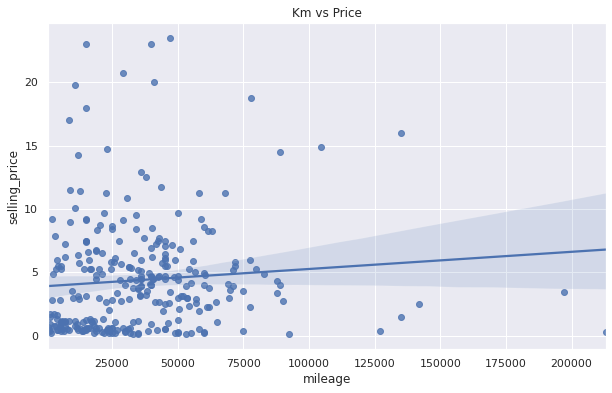

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x='mileage', y='selling_price', data=dataset).set_title('Km vs Price')

In [ ]:
dataset.shape


(294, 9)

In [ ]:
dataset = dataset[dataset.mileage < 100000]
dataset.shape


(287, 9)

Text(0.5, 1.0, 'Km vs Price')

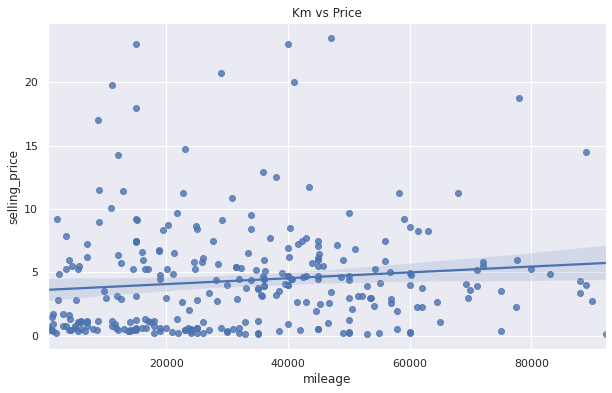

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x='mileage', y='selling_price', data=dataset).set_title('Km vs Price')

Text(0.5, 1.0, 'age vs Price')

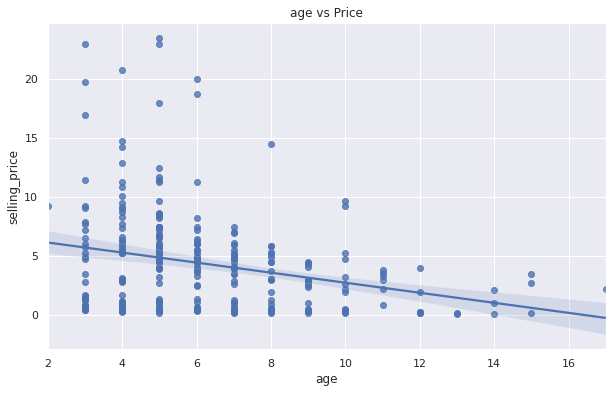

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x='age', y='selling_price', data=dataset).set_title('age vs Price')

## Correlation matrix


In [ ]:
print(dataset.corr())
corr = dataset.corr()

                       year   mileage  ...  selling_price       age
year               1.000000 -0.589181  ...       0.264773 -1.000000
mileage           -0.589181  1.000000  ...       0.114248  0.589181
fuel_type         -0.081776 -0.244087  ...      -0.492029  0.081776
seller_type        0.012218  0.355044  ...       0.623002 -0.012218
transmission_type  0.054573 -0.004521  ...       0.359963 -0.054573
previous_owners   -0.104628 -0.034772  ...      -0.105913  0.104628
selling_price      0.264773  0.114248  ...       1.000000 -0.264773
age               -1.000000  0.589181  ...      -0.264773  1.000000

[8 rows x 8 columns]


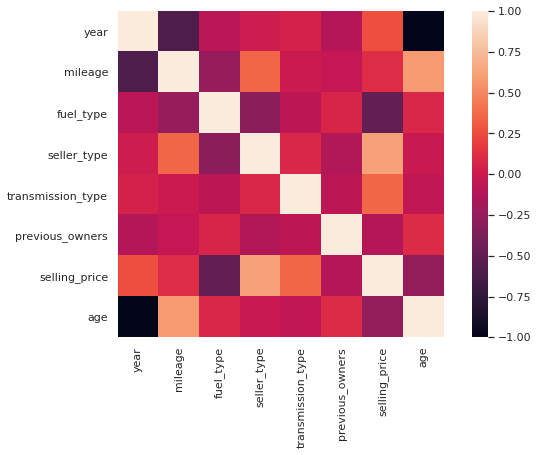

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(corr, vmax=1, square=True)

**Useful insights from Corr Heatmap**
  - Positive corr: Price highly correlated with mileage
  - Negative corr: Price negatively corr with year


In [ ]:
dataset.head()


,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price,age
0,ritz,2014.0,27000,1.0,1.0,0.0,0.0,3.35,6.0
1,sx4,2013.0,43000,0.0,1.0,0.0,0.0,4.75,7.0
2,ciaz,2017.0,6900,1.0,1.0,0.0,0.0,7.25,3.0
3,wagon,2011.0,5200,1.0,1.0,0.0,0.0,2.85,9.0
4,swift,2014.0,42450,0.0,1.0,0.0,0.0,4.60,6.0


# Split data into test and train sets

In [ ]:
X_withoutName = dataset[['mileage' ,	'fuel_type' ,	'seller_type'	,'transmission_type'	,'previous_owners'	,'age']]
y_withoutName = dataset['selling_price']

In [ ]:
X = vertical_stack[[
'Activa',	'Bajaj'	, 'Hero'	,'Honda'	,'Hyosung',	'KTM',	'Mahindra',	'Royal',	'Suzuki',	'TVS',	'UM',	'Yamaha',	'alto'	,'amaze',	'baleno'	,'brio',	'ciaz'	,'city'	,'corolla'	,'creta'	,'dzire'	,'elantra'	,'eon'	,'ertiga'	,'etios'	,'fortuner'	,'grand'	,'i10'	,'i20'	,'ignis'	,'innova'	,'jazz'	,'omni'	,'ritz'	,'s'	, 'swift'	, 'sx4' ,	'verna'	,'vitara'	,'wagon'	,'xcent' ,'mileage' ,	'fuel_type' ,	'seller_type'	,'transmission_type'	,'previous_owners'	,'age']]
y = vertical_stack['selling_price']

In [ ]:
X

,Activa,Bajaj,Hero,Honda,Hyosung,KTM,Mahindra,Royal,Suzuki,TVS,UM,Yamaha,alto,amaze,baleno,brio,ciaz,city,corolla,creta,dzire,elantra,eon,ertiga,etios,fortuner,grand,i10,i20,ignis,innova,jazz,omni,ritz,s,swift,sx4,verna,vitara,wagon,xcent,mileage,fuel_type,seller_type,transmission_type,previous_owners,age
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,27000,1.0,1.0,0.0,0.0,6.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,43000,0.0,1.0,0.0,0.0,7.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6900,1.0,1.0,0.0,0.0,3.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5200,1.0,1.0,0.0,0.0,9.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,42450,0.0,1.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33988,0.0,1.0,0.0,0.0,4.0
297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60000,1.0,1.0,0.0,0.0,5.0
298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87934,1.0,1.0,0.0,0.0,11.0
299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9000,0.0,1.0,0.0,0.0,3.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(X_withoutName, y_withoutName, random_state=42)

# Models

## Shallow learning (Machine Learning)
train on two preprocessing techniques
  - Without Car Name
  - Using One-Hot-Encoding

### Pipeline:
- Defend the model
- Fit the data
- Learning processes 
- Calculate the accuracy measure.
- Plot the prediction values
### Accurces measure:
  - R-squared (R2):

is a statistical measure that represents the goodness of fit of a regression model.
	​	 
​	

  - The Mean Squared Error (MSE):

an estimator measures the average of error squares i.e. the average squared difference between the estimated values and true value. 
   \begin{equation*}   \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i + \hat{\epsilon}_i   \end{equation*} 



### Linear Regression

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(X_train_N, y_train_N)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
scores = cross_val_score(linreg, X_train_N, y_train_N, cv=5)
print(np.mean(scores))

0.5684406354523699


In [ ]:
scores_test = cross_val_score(linreg, X_test_N, y_test_N, cv=5)
print(np.mean(scores_test))

0.6563594952954552


In [ ]:
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train_N, y_train_N)))


R-squared score (training): 0.616


In [ ]:
print('R-squared score (Testing): {:.3f}'
     .format(linreg.score(X_test_N, y_test_N)))


R-squared score (Testing): 0.668


In [ ]:
y_pred_N = linreg.predict(X_test_N)

In [ ]:
print('Mean Squared Error (MSE): {:.3f}'
     .format(mean_squared_error(y_pred_N,y_test_N)))

Mean Squared Error (MSE): 4.096


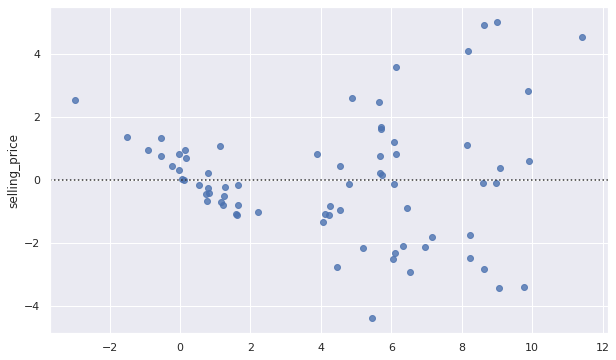

In [ ]:
plt.figure(figsize=(10,6))
sns.residplot(x=y_pred_N, y=y_test_N)

With names as one hot encoding

0.756700693678934
0.4900048122947327
R-squared score (training): 0.903
R-squared score (Testing): 0.731
Mean Squared Error (MSE): 4.105


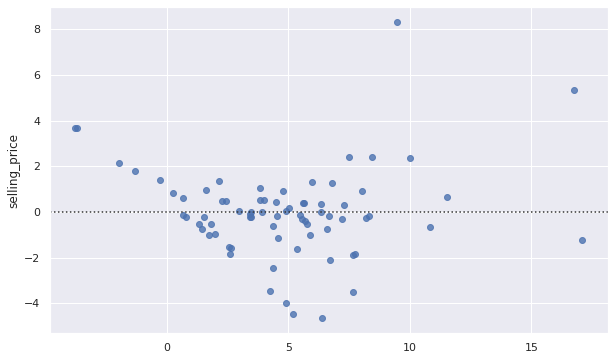

In [ ]:
linreg1 = LinearRegression()
linreg1.fit(X_train, y_train)
scores = cross_val_score(linreg1, X_train, y_train, cv=5)
print(np.mean(scores))
scores_test = cross_val_score(linreg1, X_test, y_test, cv=5)
print(np.mean(scores_test))
print('R-squared score (training): {:.3f}'
     .format(linreg1.score(X_train, y_train)))
print('R-squared score (Testing): {:.3f}'
     .format(linreg1.score(X_test, y_test)))
y_pred = linreg1.predict(X_test)
print('Mean Squared Error (MSE): {:.3f}'
     .format(mean_squared_error(y_pred,y_test)))
plt.figure(figsize=(10,6))
sns.residplot(x=y_pred, y=y_test)

#### Feature Selection using RFE & K-Fold Cross Validation
Finding optimal feature count using RFE

src: github.com/vikrantarora25

In [ ]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm

n_features_list = list(range(4, 31)) #checking for optimal number of features
train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE=[]
test_RMSE=[]

for n_features in range(4, 31):

    # RFE with n features
    lm = LinearRegression()

    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)  # specifying number of features

    # fit with n features
    rfe_n.fit(X_train, y_train)

    # selecting the features provided by rfe_n
    col_n = X_train.columns[rfe_n.support_] #rfe_n.support_: returns an array with boolean values to indicate whether 
    #an attribute was selected using RFE

    # subsetting training & test data for n selected columns
    X_train_rfe_n = X_train[col_n]
    X_test_rfe_n = X_test[col_n]


    # add a constant to the model
    X_train_rfe_n = sm.add_constant(X_train_rfe_n,has_constant='add')


    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

    
    
    # fitting the model with n featues
    lm_n = sm.OLS(y_train, X_train_rfe_n).fit()
    
    
    # # Making predictiions
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    
    #Calculating evaluation metrics
    
    #R-square
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    #RMSE/stan. error
    error_test=y_pred_test-y_test
    error_train=y_pred_train-y_train
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)


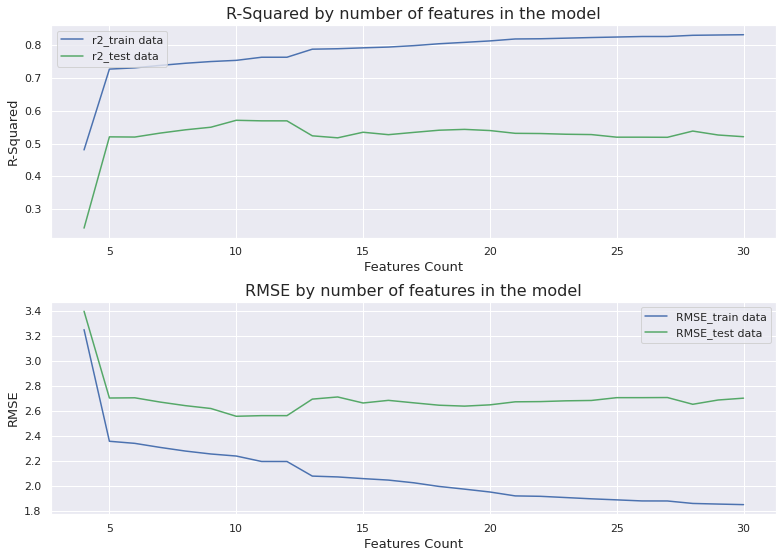

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(13, 9))
plt.subplots_adjust(hspace = 0.3)
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Features Count',fontsize=13)
ax[0].set_ylabel('R-Squared',fontsize=13)
ax[0].set_title('R-Squared by number of features in the model',fontsize=16)

ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Features Count',fontsize=13)
ax[1].set_ylabel('RMSE',fontsize=13)
ax[1].set_title('RMSE by number of features in the model',fontsize=16)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')
plt.show()

### Random forest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
regr.fit(X_train_N, y_train_N)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
print('R-squared score (training): {:.3f}'
     .format(regr.score(X_train_N, y_train_N)))

R-squared score (training): 0.951


In [ ]:
print('R-squared score (testing): {:.3f}'
     .format(regr.score(X_test_N, y_test_N)))

R-squared score (testing): 0.660


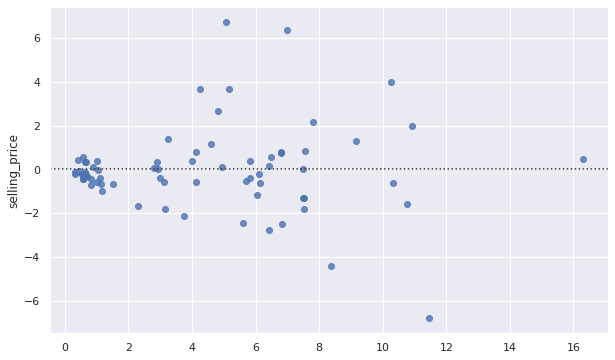

In [ ]:
y_pred_N = regr.predict(X_test_N)
plt.figure(figsize=(10,6))
sns.residplot(x=y_pred_N, y=y_test_N)

In [ ]:
print('Mean Squared Error (MSE): {:.3f}'
     .format(mean_squared_error(y_pred_N,y_test_N)))

Mean Squared Error (MSE): 4.205


With names as one hot encoding

0.8173420863997855
0.47886820218280934
R-squared score (training): 0.970
R-squared score (Testing): 0.821
Mean Squared Error (MSE): 2.723


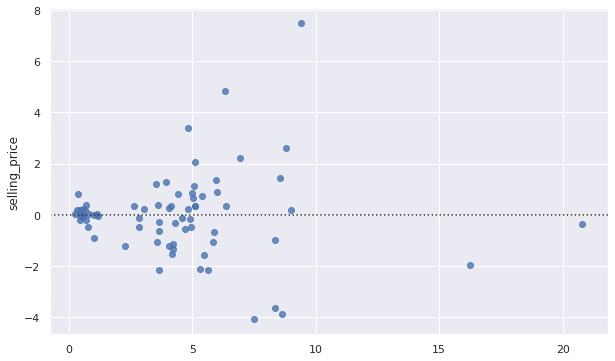

In [ ]:
regr1 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
regr1.fit(X_train, y_train)
scores = cross_val_score(regr1, X_train, y_train, cv=5)
print(np.mean(scores))
scores_test = cross_val_score(regr1, X_test, y_test, cv=5)
print(np.mean(scores_test))
print('R-squared score (training): {:.3f}'
     .format(regr1.score(X_train, y_train)))
print('R-squared score (Testing): {:.3f}'
     .format(regr1.score(X_test, y_test)))
y_pred = regr1.predict(X_test)
print('Mean Squared Error (MSE): {:.3f}'
     .format(mean_squared_error(y_pred,y_test)))
plt.figure(figsize=(10,6))
sns.residplot(x=y_pred, y=y_test)

Text(0.5, 0, 'Index')

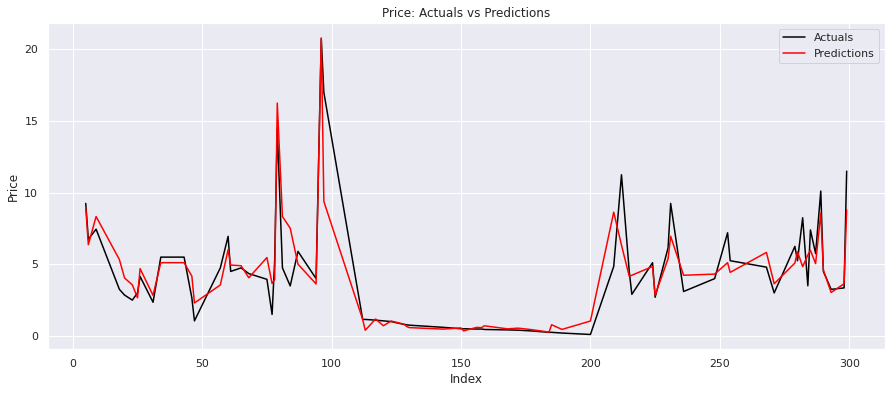

In [ ]:

fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_test.index,y=y_test,label='Actuals',color='black',ax=ax)
sns.lineplot(x=y_test.index,y=y_pred,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions')
ax.set_ylabel('Price')
ax.set_xlabel('Index')

#### Feature Selection using RFE & K-Fold Cross Validation
Finding optimal feature count using RFE

src: github.com/vikrantarora25

In [ ]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm

n_features_list = list(range(4, 31)) #checking for optimal number of features
train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE=[]
test_RMSE=[]

for n_features in range(4, 31):

    # RFE with n features
    lm = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)

    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)  # specifying number of features

    # fit with n features
    rfe_n.fit(X_train, y_train)

    # selecting the features provided by rfe_n
    col_n = X_train.columns[rfe_n.support_] #rfe_n.support_: returns an array with boolean values to indicate whether 
    #an attribute was selected using RFE

    # subsetting training & test data for n selected columns
    X_train_rfe_n = X_train[col_n]
    X_test_rfe_n = X_test[col_n]


    # add a constant to the model
    X_train_rfe_n = sm.add_constant(X_train_rfe_n,has_constant='add')


    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

    
    
    # fitting the model with n featues
    lm_n = sm.OLS(y_train, X_train_rfe_n).fit()
    
    
    # # Making predictiions
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    
    #Calculating evaluation metrics
    
    #R-square
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    #RMSE/stan. error
    error_test=y_pred_test-y_test
    error_train=y_pred_train-y_train
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)

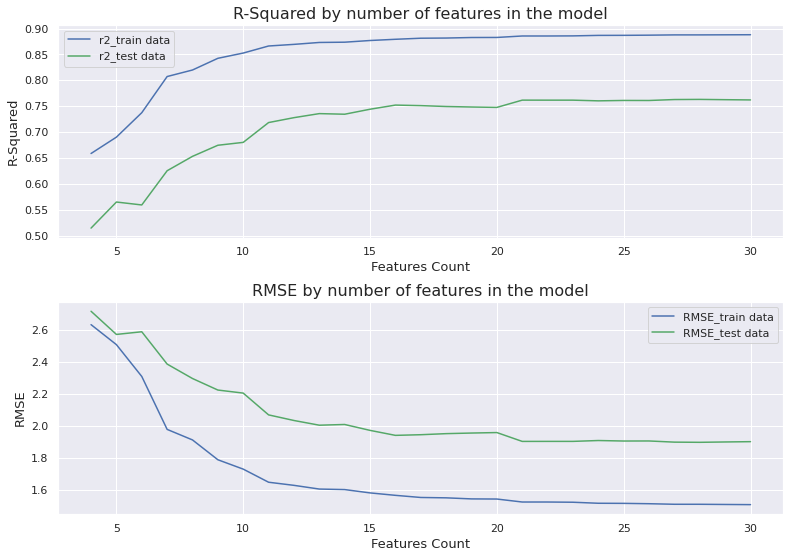

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(13, 9))
plt.subplots_adjust(hspace = 0.3)
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Features Count',fontsize=13)
ax[0].set_ylabel('R-Squared',fontsize=13)
ax[0].set_title('R-Squared by number of features in the model',fontsize=16)

ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Features Count',fontsize=13)
ax[1].set_ylabel('RMSE',fontsize=13)
ax[1].set_title('RMSE by number of features in the model',fontsize=16)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')
plt.show()

### Suport vector regration 

In [ ]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
regressor = SVR(kernel='poly') 
regressor.fit(X_train_N, y_train_N)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
print('R-squared score (training): {:.3f}'
     .format(regressor.score(X_train_N, y_train_N)))

R-squared score (training): -0.038


In [ ]:
print('R-squared score (training): {:.3f}'
     .format(regressor.score(X_test_N, y_test_N)))

R-squared score (training): 0.026


In [ ]:
# 5 Predicting a new result
y_pred_N = regressor.predict(X_test_N)

In [ ]:
print('Mean Squared Error (MSE): {:.3f}'
     .format(mean_squared_error(y_pred_N,y_test_N)))

Mean Squared Error (MSE): 12.037


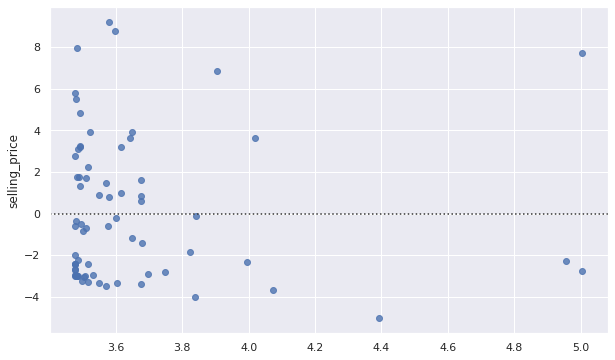

In [ ]:
plt.figure(figsize=(10,6))
sns.residplot(x=y_pred_N, y=y_test_N)

With names as one hot encoding

-0.06248711172919501
-0.16154794058359725
R-squared score (training): -0.041
R-squared score (Testing): -0.042
Mean Squared Error (MSE): 15.883


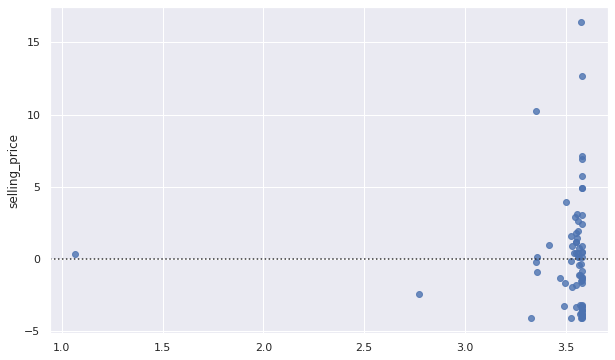

In [ ]:
regressor1 = SVR(kernel='poly')  # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
regressor1.fit(X_train, y_train)
scores = cross_val_score(regressor1, X_train, y_train, cv=5)
print(np.mean(scores))
scores_test = cross_val_score(regressor1, X_test, y_test, cv=5)
print(np.mean(scores_test))
print('R-squared score (training): {:.3f}'
     .format(regressor1.score(X_train, y_train)))
print('R-squared score (Testing): {:.3f}'
     .format(regressor1.score(X_test, y_test)))
y_pred = regressor1.predict(X_test)
print('Mean Squared Error (MSE): {:.3f}'
     .format(mean_squared_error(y_pred,y_test)))
plt.figure(figsize=(10,6))
sns.residplot(x=y_pred, y=y_test)

## Deep Learning


Based on what we found from the models of ML :
One-Hot-encoding give higher results, so in the deep learning models we used it

### Pipeline 
- Create model 
  - Number of dense lyers 
  - Loss function
  - Optimizer
- Evaluate model
  - Cross-Validation with 10 k-folds
  - Calculate MSE

### CNN
src: https://machinelearningmastery.comregression-tutorial-keras-deep-learning-library-python/

In [ ]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(47 , input_dim=47 , kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -27.59 (22.26) MSE


In [ ]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(47, input_dim=47, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -4.05 (4.91) MSE


In [ ]:
# define the model
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(47, input_dim=47, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std())) 
# The smaller the means squared error, the closer you are to finding the line of best fit.

Larger: -4.19 (5.26) MSE


# Conda setup 
src: https://towardsdatascience.com/conda-google-colab-75f7c867a522

In [ ]:
!which python # should return /usr/local/bin/python


/usr/local/bin/python


In [ ]:
!python --version


Python 3.6.9


In [ ]:
!echo $PYTHONPATH


/env/python


In [ ]:
%env PYTHONPATH=


env: PYTHONPATH=


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2020-07-14 10:56:58--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2020-07-14 10:56:58--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 3.95M 14s
    50K .......... .......... .......... .......... ..........  0

In [ ]:
!which conda # should return /usr/local/bin/conda


/usr/local/bin/conda


In [ ]:
!conda --version # should return 4.5.4


conda 4.5.4


In [ ]:
!which python # still returns /usr/local/bin/python


/usr/local/bin/python


In [ ]:
!python --version # now returns Python 3.6.5 :: Anaconda, Inc.


Python 3.6.5 :: Anaconda, Inc.


In [ ]:
%%bash
conda install --channel defaults conda python=3.6 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - conda
    - python=3.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    sqlite-3.32.3              |       h62c20be_0         2.0 MB
    yaml-0.2.5                 |       h7b6447c_0          87 KB
    idna-2.10                  |             py_0          56 KB
    certifi-2020.6.20          |           py36_0         160 KB
    cryptography-2.9.2         |   py36h1ba5d50_0         626 KB
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB
    six-1.15.0                 |             py_0          13 KB
    tk-8.6.10                  |       hbc83047_0         3.2 MB
    zlib-1.2.11                |       h7b6447c_3         120 KB
    requests-2.24.0            |             py_0          54 KB
    cffi-1.14.0                |   py36he30daa8_1   

sqlite-3.32.3        |  2.0 MB | ########## | 100% 
yaml-0.2.5           |   87 KB | ########## | 100% 
idna-2.10            |   56 KB | ########## | 100% 
certifi-2020.6.20    |  160 KB | ########## | 100% 
cryptography-2.9.2   |  626 KB | ########## | 100% 
openssl-1.1.1g       |  3.8 MB | ########## | 100% 
six-1.15.0           |   13 KB | ########## | 100% 
tk-8.6.10            |  3.2 MB | ########## | 100% 
zlib-1.2.11          |  120 KB | ########## | 100% 
requests-2.24.0      |   54 KB | ########## | 100% 
cffi-1.14.0          |  226 KB | ########## | 100% 
ld_impl_linux-64-2.3 |  645 KB | ########## | 100% 
_libgcc_mutex-0.1    |    3 KB | ########## | 100% 
ca-certificates-2020 |  133 KB | ########## | 100% 
xz-5.2.5             |  438 KB | ########## | 100% 
python-3.6.10        | 33.9 MB | ########## | 100% 
wheel-0.34.2         |   49 KB | ########## | 100% 
libffi-3.3           |   54 KB | ########## | 100% 
tqdm-4.47.0          |   62 KB | ########## | 100% 
conda-packag

In [ ]:
!conda --version # now returns 4.8.3


conda 4.8.3


In [ ]:
!python --version # now returns Python 3.6.10 :: Anaconda, Inc.


Python 3.6.10 :: Anaconda, Inc.


In [ ]:
!conda install -c https://conda.anaconda.org/conda-forge wordcloud


Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    conda-4.8.3                |   py36h9f0ad1d_1         3.0 MB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    freetype-2.10.2            |       he06d7ca_0         905 KB  conda-forge
    icu-67.1                   |       he1b5a44_0        12.9 MB  conda-forge
    jpeg-9d                    |       h516909a_0         266 KB  conda-forge
    kiwisolver-1.2.0           |   py36hdb11119_0          87 KB  conda-forge
    lc